# Feature engineering consumption level

In [1]:
# importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pyarrow
import fastparquet
from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter('ignore')

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import itertools

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# import data with client ID

In [37]:
date_format_client = {"creation_date": "%d/%m/%Y"}
date_format_invoice = {"invoice_date": "%Y-%m-%d"}

# Import CSVs

client_train = pd.read_csv(
    "data/client_train.csv",
    parse_dates=["creation_date"],
    date_format=date_format_client,
    low_memory=False,
)

invoice_train = pd.read_csv(
    "data/invoice_train.csv",
    parse_dates=["invoice_date"],
    date_format=date_format_invoice,
    low_memory=False,
)

In [38]:
df_train = pd.merge(client_train, invoice_train, how='left', on='client_id')

In [39]:
def data_cleaning(df):

    # First convert 'A' to a number (for example 99) or drop those rows
    df["counter_statue"] = df["counter_statue"].replace("A", 99)

    # Then convert the column to integer type
    df["counter_statue"] = df["counter_statue"].astype(int)

    # Now you can filter as before
    df = df[~(df["counter_statue"] > 5)]

    # drop months number >12
    df = df[df["months_number"] <= 12]

    # drop invoice dates before 2005
    df = df[df["invoice_date"] >= pd.to_datetime("2005-01-01", format="%Y-%m-%d")]

    # drop the counter number, there are a lot of 0 values in both train and test data
    df = df.drop("counter_number", axis=1)

    return df

In [40]:
data_cleaning(df_train)

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,1994-12-31,0.0,2014-03-24,11,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,1994-12-31,0.0,2013-03-29,11,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,1994-12-31,0.0,2015-03-23,11,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,1994-12-31,0.0,2015-07-13,11,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,1994-12-31,0.0,2016-11-17,11,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476741,63,train_Client_99997,11,311,2011-11-22,0.0,2014-02-17,40,0,5,9,1,118,0,0,0,406,524,4,GAZ
4476742,63,train_Client_99997,11,311,2011-11-22,0.0,2014-06-13,11,0,207,9,1,312,0,0,0,2562,2874,4,ELEC
4476743,63,train_Client_99997,11,311,2011-11-22,0.0,2019-11-06,11,0,207,9,1,578,0,0,0,8505,9083,4,ELEC
4476744,60,train_Client_99998,11,101,1993-12-22,0.0,2005-08-19,10,0,202,9,1,400,135,0,0,3197,3732,8,ELEC


In [3]:
df_train.columns

Index(['creation_date', 'target', 'counter_coefficient',
       'consommation_level_1', 'consommation_level_2', 'consommation_level_3',
       'consommation_level_4', 'months_number', 'counter_type_ELEC',
       'counter_type_GAZ', 'reading_remarque', 'counter_statue', 'disrict_60',
       'disrict_62', 'disrict_63', 'disrict_69', 'client_catg_11',
       'client_catg_12', 'client_catg_51', 'region_101', 'region_103',
       'region_104', 'region_105', 'region_106', 'region_107', 'region_199',
       'region_206', 'region_301', 'region_302', 'region_303', 'region_304',
       'region_305', 'region_306', 'region_307', 'region_308', 'region_309',
       'region_310', 'region_311', 'region_312', 'region_313', 'region_371',
       'region_372', 'region_379', 'region_399', 'tarif_type_10',
       'tarif_type_11', 'tarif_type_12', 'tarif_type_13', 'tarif_type_14',
       'tarif_type_15', 'tarif_type_18', 'tarif_type_21', 'tarif_type_24',
       'tarif_type_27', 'tarif_type_29', 'tarif_type_4

In [41]:
df_consumption = df_train[['client_id', 'target', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3',
       'consommation_level_4', 'months_number']]

In [42]:
df_consumption_normalized = df_consumption.copy()


In [43]:
df_consumption_normalized = df_consumption_normalized[df_consumption_normalized['months_number'] != 0]

In [44]:
# normalize the data

df_consumption_normalized['consommation_level_1'] = df_consumption_normalized['consommation_level_1'] / df_consumption_normalized['months_number']
df_consumption_normalized['consommation_level_2'] = df_consumption_normalized['consommation_level_2'] / df_consumption_normalized['months_number']
df_consumption_normalized['consommation_level_3'] = df_consumption_normalized['consommation_level_3'] / df_consumption_normalized['months_number']
df_consumption_normalized['consommation_level_4'] = df_consumption_normalized['consommation_level_4'] / df_consumption_normalized['months_number']

In [32]:
corr = df_consumption_normalized.corr()

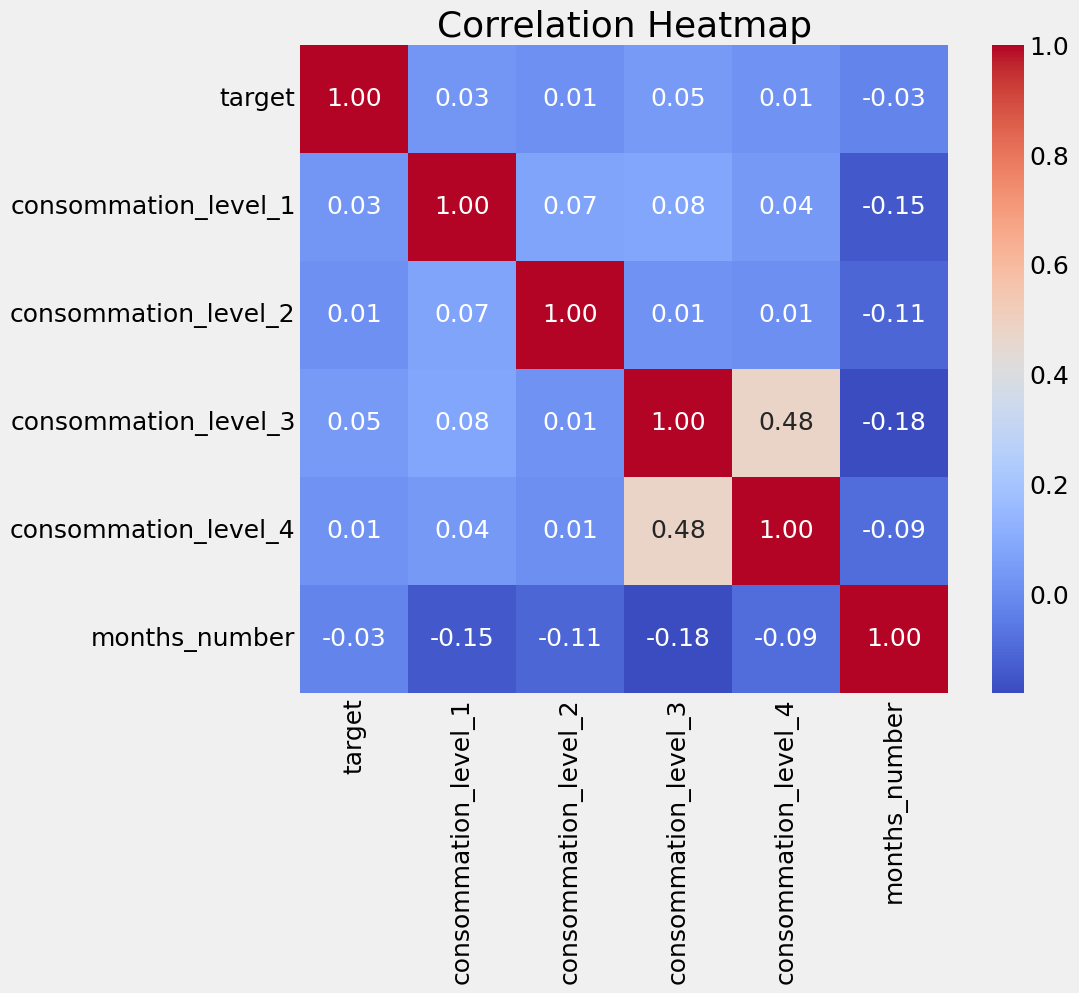

In [33]:
# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [65]:
aggcol = ['min', 'max', 'median', 'sum', 'std']

aggregated = df_consumption_normalized.groupby('client_id').agg({
    'consommation_level_1': aggcol,
    'consommation_level_2': aggcol,
    'consommation_level_3': aggcol,
    'consommation_level_4': aggcol,
    'target': 'mean'
})

In [66]:
aggregated.columns = [
    '_'.join(col).strip() if isinstance(col, tuple) else col
    for col in aggregated.columns.values
]
aggregated = aggregated.reset_index()
aggregatednum = aggregated.select_dtypes(include='number')

In [67]:
corr = aggregatednum.corr()

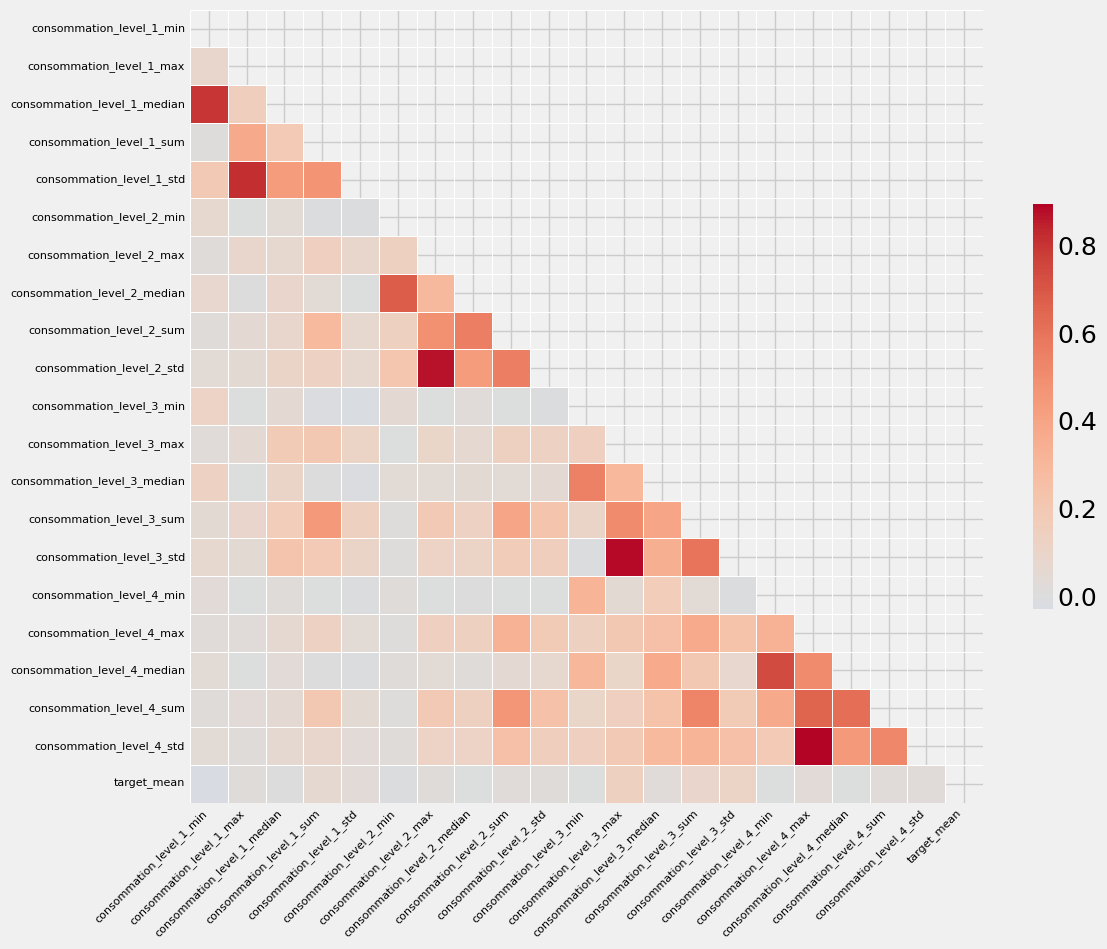

In [68]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
sns.scatterplot(x=aggregated['consommation_level_3_max'], y=aggregated['client_id'], hue=aggregated['target_mean'])